In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

# Step 1: Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from mord import LogisticIT
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Stats
from scipy import stats
from scipy.stats import shapiro
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

# SHAP
import shap

# Step 2: Load the dataset

In [3]:
df = pd.read_excel('INSS 795 Project Hypothetical Farmers_data.xlsx')
df.head()

,Farmer ID,Technology Adoption Level,Crop Yield,Labor Hours,Financial Investment in Technology,Perceived Well-being,Environmental Impact Metrics
0,F01127,NaN,3.657347,1251.843684,6342.097206,7.0,74.618754
1,F10846,Full,5.470678,565.616891,131.970358,5.0,74.878932
2,F08887,Partial,4.931889,1448.417467,3274.956322,6.0,67.696773
3,F09207,Partial,3.555740,879.411591,890.995607,7.0,54.222245
4,F00029,Partial,4.914841,1255.951865,981.738815,4.0,48.920666


# Step 3: Data Cleaning

## Drop duplicates recods

In [4]:
df = df.drop_duplicates()

## Check missing values

In [5]:
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Farmer ID                                0
Technology Adoption Level             3345
Crop Yield                            1095
Labor Hours                           1091
Financial Investment in Technology    1032
Perceived Well-being                   544
Environmental Impact Metrics           534
dtype: int64


## Fill missing values with median for numerical data

In [6]:
num_cols = ['Labor Hours', 'Financial Investment in Technology', 'Environmental Impact Metrics', 'Crop Yield']
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))

## Drop rows with missing ordinal data

In [7]:
df = df.dropna(subset=['Perceived Well-being'])

# Step 4: Data Transformation

## Encoding

In [8]:
df['Technology Adoption Level'] = df['Technology Adoption Level'].fillna('None')
encoder = OrdinalEncoder(categories=[['None', 'Partial', 'Full']])
df['Tech_Level_Encoded'] = encoder.fit_transform(df[['Technology Adoption Level']])

## Normalize numerical features

In [9]:
scaler = StandardScaler()
scaled_cols = ['Labor Hours', 'Financial Investment in Technology', 'Environmental Impact Metrics']
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

## Classification Model Setup

### ---- Ordinal Regression Target ----

In [10]:
y_ord = df['Perceived Well-being'].astype(int)

### ---- Classification Target (3 classes) ----

In [11]:
def map_wellbeing(val):
    if val < 4:
        return 'Low'
    elif val <= 7:
        return 'Moderate'
    else:
        return 'High'

df['Wellbeing_Class'] = df['Perceived Well-being'].apply(map_wellbeing)
y_cls = df['Wellbeing_Class']

# Step 5: Exploration Analysis

## Correlation Heatmap

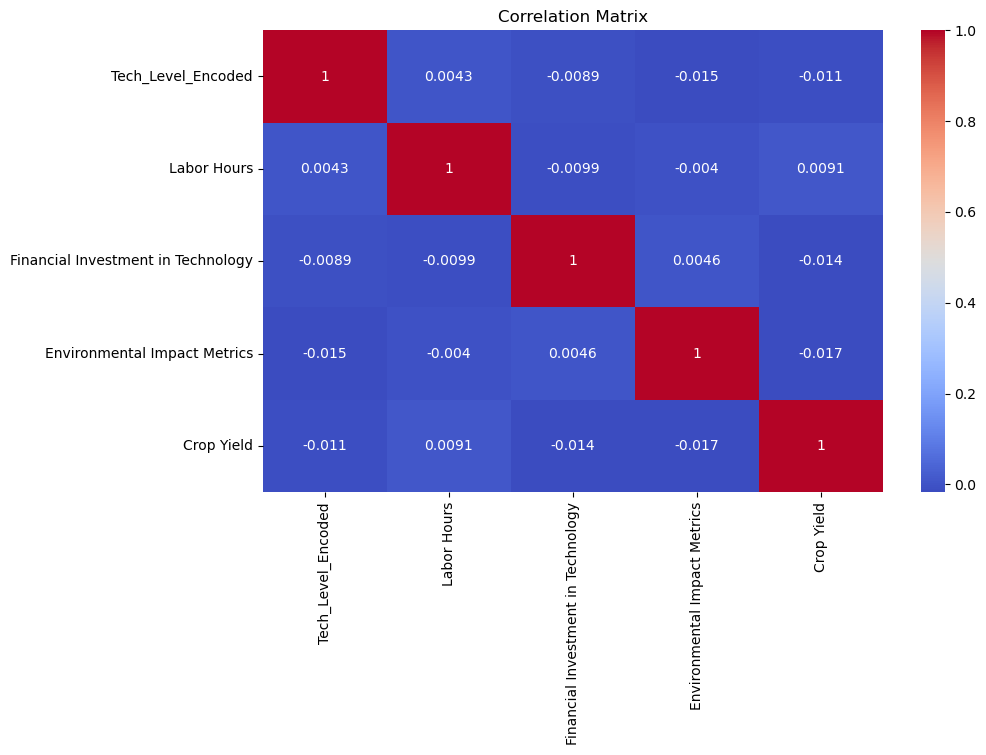

In [12]:
corr = df[['Tech_Level_Encoded'] + scaled_cols + ['Crop Yield']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## Boxplot: Technology Adoption vs Crop Yield

C:\Users\HP\AppData\Local\Temp\ipykernel_13016\1453220391.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Technology Adoption Level', y='Crop Yield', palette='Set3')


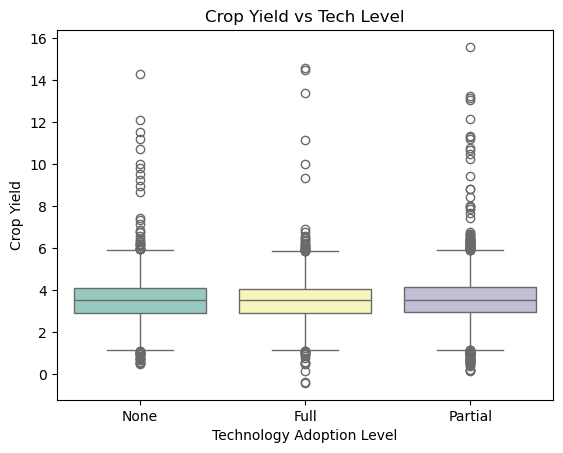

In [13]:
sns.boxplot(data=df, x='Technology Adoption Level', y='Crop Yield', palette='Set3')
plt.title("Crop Yield vs Tech Level")
plt.show()

## Distribution of Perceived Well-being

C:\Users\HP\AppData\Local\Temp\ipykernel_13016\1038490961.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Perceived Well-being', palette='viridis')


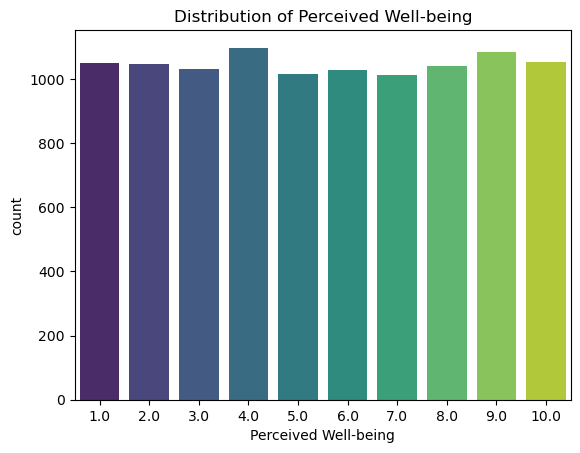

In [14]:
sns.countplot(data=df, x='Perceived Well-being', palette='viridis')
plt.title("Distribution of Perceived Well-being")
plt.show()

# Step 6: Experiment

## Spliting the Data Linear Regression: Crop Yield

In [15]:
features = ['Tech_Level_Encoded', 'Labor Hours', 'Financial Investment in Technology', 'Environmental Impact Metrics']
X_reg = df[features]
y_reg = df['Crop Yield']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

## Spliting the Data Clssification Regression: Perceived Well-being

In [16]:
X = df[features]

# Ordinal Regression
X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(X, y_ord, test_size=0.2, random_state=42)

# Classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls, test_size=0.2, random_state=42)

## Train Regression Model

In [17]:
regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Train regression models
for name, model in regressors.items():
    model.fit(X_train_reg, y_train_reg)
    print(f"{name} trained successfully.")

Linear Regression trained successfully.
Random Forest trained successfully.
XGBoost trained successfully.


## Train Ordinal Logistic Regression (LogisticIT)

In [18]:
ord_model = LogisticIT()
ord_model.fit(X_train_ord, y_train_ord)

LogisticIT()

In [19]:
## Train Classification Model (3-Class)

In [20]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42)
}

for name, model in classifiers.items():
    model.fit(X_train_cls, y_train_cls)
    print(f"{name} trained successfully.")

Logistic Regression trained successfully.
Random Forest trained successfully.


# Step 7: Evaluation

## Regression Metrics

In [21]:
regression_results = []

for name, model in regressors.items():
    y_pred = model.predict(X_test_reg)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    r2 = r2_score(y_test_reg, y_pred)
    regression_results.append({
        'Model': name,
        'RMSE': round(rmse, 3),
        'R² Score': round(r2, 3)
    })

regression_results_df = pd.DataFrame(regression_results)
regression_results_df

,Model,RMSE,R² Score
0,Linear Regression,0.991,0.000
1,Random Forest,1.056,-0.135
2,XGBoost,1.075,-0.177


## Feature Importance

In [22]:
rf = regressors['Random Forest']
feat_df = pd.DataFrame({'Feature': X_reg.columns, 'Importance': rf.feature_importances_}) \
    .sort_values(by='Importance', ascending=False)

# Display the table
feat_df

,Feature,Importance
3,Environmental Impact Metrics,0.326946
2,Financial Investment in Technology,0.314123
1,Labor Hours,0.310985
0,Tech_Level_Encoded,0.047947


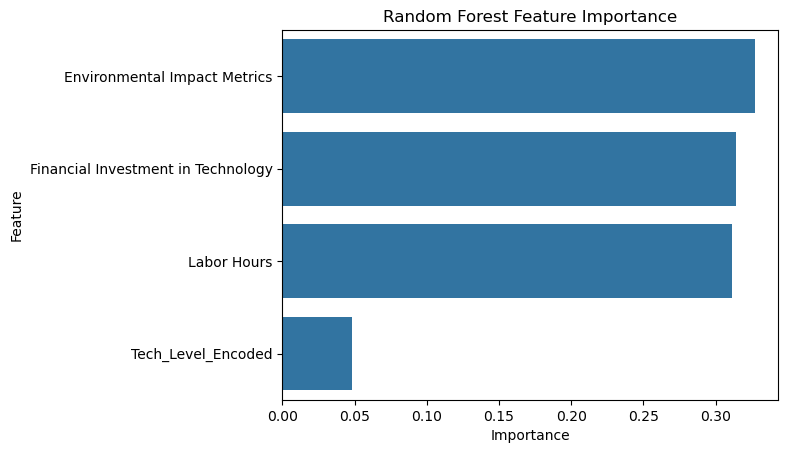

In [23]:
# Plot Features Importance
sns.barplot(data=feat_df, x='Importance', y='Feature')
plt.title("Random Forest Feature Importance")
plt.show()

## Ordinal Logistic Regression (LogisticIT) Metric

In [24]:
y_pred_ord = ord_model.predict(X_test_ord)

# Ordinal Logistic Regression Summary (LogisticIT)
print("Ordinal Logistic Regression Summary (LogisticIT)\n")
print("Features used:", list(X.columns))

# Coefficients
print("\nModel Coefficients:")
for feature, coef in zip(X.columns, ord_model.coef_):
    print(f"  {feature}: {coef:.4f}")

# Thresholds (cutpoints between categories)
print("\nThresholds (Theta values):")
for i, theta in enumerate(ord_model.theta_):
    print(f"  Threshold {i+1}: {theta:.4f}")

# Accuracy
acc = accuracy_score(y_test_ord, y_pred_ord)
print(f"\nPrediction Accuracy: {acc:.3f}")

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_ord, y_pred_ord))

Ordinal Logistic Regression Summary (LogisticIT)

Features used: ['Tech_Level_Encoded', 'Labor Hours', 'Financial Investment in Technology', 'Environmental Impact Metrics']

Model Coefficients:
  Tech_Level_Encoded: -0.0095
  Labor Hours: 0.0036
  Financial Investment in Technology: -0.0039
  Environmental Impact Metrics: -0.0025

Thresholds (Theta values):
  Threshold 1: -0.0240
  Threshold 2: -0.0240
  Threshold 3: -0.0240
  Threshold 4: -0.0050
  Threshold 5: -0.0050
  Threshold 6: -0.0050
  Threshold 7: -0.0050
  Threshold 8: -0.0050
  Threshold 9: 0.0266

Prediction Accuracy: 0.095

Confusion Matrix:
[[  5   0   0 120   0   0   0   0  74   0]
 [  5   0   0 127   0   0   0   0  72   0]
 [  7   0   0 128   0   0   0   0  67   0]
 [  9   0   0 124   0   0   0   0  76   0]
 [  9   0   0 124   0   0   0   0  77   0]
 [ 10   0   0 118   0   0   0   0  88   0]
 [  6   0   0 134   0   0   0   0  74   0]
 [  9   0   0 143   0   0   0   0  69   0]
 [  9   0   0 132   0   0   0   0  69   0]


## Classification Model

In [50]:
classification_results = []

for name, model in classifiers.items():
    preds = model.predict(X_test_cls)
    acc = accuracy_score(y_test_cls, preds)
    classification_results.append({
        'Model': name,
        'Accuracy': round(acc, 3)
    })

classification_results_df = pd.DataFrame(classification_results)
classification_results_df

,Model,Accuracy
0,Logistic Regression,0.406
1,Random Forest,0.360


In [67]:
for name, model in classifiers.items():
    print(f"\n{name} Classification Results:")

    y_pred_cls = model.predict(X_test_cls)
    acc = accuracy_score(y_test_cls, y_pred_cls)
    print(f"Accuracy: {acc:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_cls, y_pred_cls))
    print("Classification Report:")
    print(classification_report(y_test_cls, y_pred_cls))

    # Sample predictions
    print("\nSample Predictions:")
    sample_df = pd.DataFrame({
        "Actual": y_test_cls.reset_index(drop=True),
        "Predicted": y_pred_cls
    })
    display(sample_df.head(10))


Logistic Regression Classification Results:
Accuracy: 0.406
Confusion Matrix:
[[  0   0 638]
 [  1   3 601]
 [  0   3 846]]
Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00       638
         Low       0.50      0.00      0.01       605
    Moderate       0.41      1.00      0.58       849

    accuracy                           0.41      2092
   macro avg       0.30      0.33      0.20      2092
weighted avg       0.31      0.41      0.24      2092


Sample Predictions:


,Actual,Predicted
0,Moderate,Moderate
1,Moderate,Moderate
2,Moderate,Moderate
3,Low,Moderate
4,Moderate,Moderate
5,High,Moderate
6,High,Moderate
7,High,Moderate
8,Low,Moderate
9,Low,Moderate



Random Forest Classification Results:
Accuracy: 0.360
Confusion Matrix:
[[187 154 297]
 [164 157 284]
 [231 209 409]]
Classification Report:
              precision    recall  f1-score   support

        High       0.32      0.29      0.31       638
         Low       0.30      0.26      0.28       605
    Moderate       0.41      0.48      0.44       849

    accuracy                           0.36      2092
   macro avg       0.35      0.34      0.34      2092
weighted avg       0.35      0.36      0.35      2092


Sample Predictions:


,Actual,Predicted
0,Moderate,Moderate
1,Moderate,Moderate
2,Moderate,Low
3,Low,Low
4,Moderate,Moderate
5,High,Low
6,High,Low
7,High,Moderate
8,Low,Moderate
9,Low,Low


# Step 8: Cross-Validation

## Cross-Validation for Regression Model

In [53]:
for name, model in regressors.items():
    scores = cross_val_score(model, X_reg, y_reg, cv=5, scoring='neg_root_mean_squared_error')
    print(f"{name}: CV RMSE = {-scores.mean():.3f} ± {scores.std():.3f}")

Linear Regression: CV RMSE = 1.051 ± 0.016
Random Forest: CV RMSE = 1.102 ± 0.015
XGBoost: CV RMSE = 1.129 ± 0.022


## Cross-Validation for Ordinal Regression

In [54]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
acc_scores = []
for train_idx, val_idx in kf.split(X, y_ord):
    model = LogisticIT()
    model.fit(X.iloc[train_idx], y_ord.iloc[train_idx])
    preds = model.predict(X.iloc[val_idx])
    acc_scores.append(accuracy_score(y_ord.iloc[val_idx], preds))

print(f"\nOrdinal CV Accuracy: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")


Ordinal CV Accuracy: 0.102 ± 0.005


## Cross-Validation for Classification Model

In [55]:
for name, model in classifiers.items():
    scores = cross_val_score(model, X, y_cls, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

Logistic Regression CV Accuracy: 0.397 ± 0.000
Random Forest CV Accuracy: 0.348 ± 0.005


# Step 9: Hyperparameter Tuning (Random Forest)

## Hyperparameter Tuning for Regression metrics

In [56]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42),
                    param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid.fit(X_train_reg, y_train_reg)

best_rf_params = grid.best_params_
best_rf_rmse = -grid.best_score_

print("Best Params:", best_rf_params)
print("Best CV RMSE:", round(best_rf_rmse, 3))

Best Params: {'max_depth': 5, 'n_estimators': 200}
Best CV RMSE: 1.071


## Hyperparameter Tuning for Classification Metric

In [57]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                       param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_cls, y_train_cls)

print("\nBest Random Forest Params:")
print(grid_rf.best_params_)
print(f"Best CV Accuracy: {grid_rf.best_score_:.3f}")


Best Random Forest Params:
{'max_depth': 5, 'n_estimators': 100}
Best CV Accuracy: 0.394


# Step 10: Post-Hoc ANOVA + Tukey

## Crop Yield

In [58]:
df['Yield_Category'] = pd.qcut(df['Crop Yield'], q=3, labels=['Low', 'Medium', 'High'])
group_col = 'Yield_Category'

regression_anova_results = []

print("One-Way ANOVA & Tukey HSD for Each Feature (Grouped by Crop Yield)\n")

# Loop through each numeric feature
for col in features:
    # One-Way ANOVA
    groups = [group[col].values for name, group in df.groupby(group_col)]
    f_stat, p_val = stats.f_oneway(*groups)
    regression_anova_results.append({
        'Feature': col,
        'F-Statistic': round(f_stat, 4),
        'p-value': round(p_val, 5)
    })

    print(f"\nFeature: {col}")
    print(f"F-Statistic: {f_stat:.4f}, p-value: {p_val:.5f}")

    if p_val < 0.05:
        print("Significant difference found — performing Tukey HSD:")
        tukey = pairwise_tukeyhsd(endog=df[col], groups=df[group_col], alpha=0.05)
        print(tukey)
    else:
        print("No significant difference found — skipping Tukey test.")

# Summary Table
regression_anova_df = pd.DataFrame(regression_anova_results)
display(regression_anova_df)

One-Way ANOVA & Tukey HSD for Each Feature (Grouped by Crop Yield)


Feature: Tech_Level_Encoded
F-Statistic: 1.3844, p-value: 0.25051
No significant difference found — skipping Tukey test.

Feature: Labor Hours
F-Statistic: 0.8726, p-value: 0.41789
No significant difference found — skipping Tukey test.

Feature: Financial Investment in Technology
F-Statistic: 0.2896, p-value: 0.74858
No significant difference found — skipping Tukey test.

Feature: Environmental Impact Metrics
F-Statistic: 0.4320, p-value: 0.64919
No significant difference found — skipping Tukey test.


C:\Users\HP\AppData\Local\Temp\ipykernel_13016\3919898410.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group[col].values for name, group in df.groupby(group_col)]


,Feature,F-Statistic,p-value
0,Tech_Level_Encoded,1.3844,0.25051
1,Labor Hours,0.8726,0.41789
2,Financial Investment in Technology,0.2896,0.74858
3,Environmental Impact Metrics,0.4320,0.64919


## Perceived Well-being

In [59]:
group_col = 'Wellbeing_Class'
classification_anova_results = []

print("One-Way ANOVA & Tukey HSD for Each Feature (Grouped by Wellbeing_Class)\n")

# Loop through each numeric feature
for col in features:
    # Grouped values for ANOVA
    groups = [group[col].values for name, group in df.groupby(group_col)]
    
    # Perform One-Way ANOVA
    f_stat, p_val = stats.f_oneway(*groups)
    
    # Append results
    classification_anova_results.append({
        'Feature': col,
        'F-Statistic': round(f_stat, 4),
        'p-value': round(p_val, 5)
    })

    print(f"\nFeature: {col}")
    print(f"F-Statistic: {f_stat:.4f}, p-value: {p_val:.5f}")

    if p_val < 0.05:
        print("Significant difference found — performing Tukey HSD:")
        tukey = pairwise_tukeyhsd(endog=df[col], groups=df[group_col], alpha=0.05)
        print(tukey)
    else:
        print("No significant difference found — skipping Tukey test.")

# Summary Table
classification_anova_df = pd.DataFrame(classification_anova_results)
display(classification_anova_df)

One-Way ANOVA & Tukey HSD for Each Feature (Grouped by Wellbeing_Class)


Feature: Tech_Level_Encoded
F-Statistic: 1.1725, p-value: 0.30963
No significant difference found — skipping Tukey test.

Feature: Labor Hours
F-Statistic: 0.3121, p-value: 0.73194
No significant difference found — skipping Tukey test.

Feature: Financial Investment in Technology
F-Statistic: 0.8451, p-value: 0.42955
No significant difference found — skipping Tukey test.

Feature: Environmental Impact Metrics
F-Statistic: 0.8103, p-value: 0.44475
No significant difference found — skipping Tukey test.


,Feature,F-Statistic,p-value
0,Tech_Level_Encoded,1.1725,0.30963
1,Labor Hours,0.3121,0.73194
2,Financial Investment in Technology,0.8451,0.42955
3,Environmental Impact Metrics,0.8103,0.44475


# Step 11: Assumption Checks

##  Linear Model

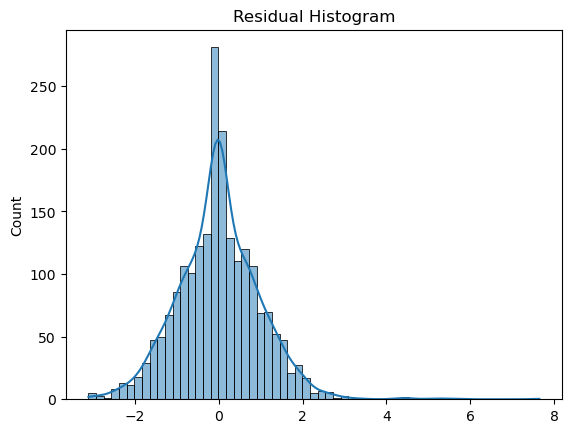

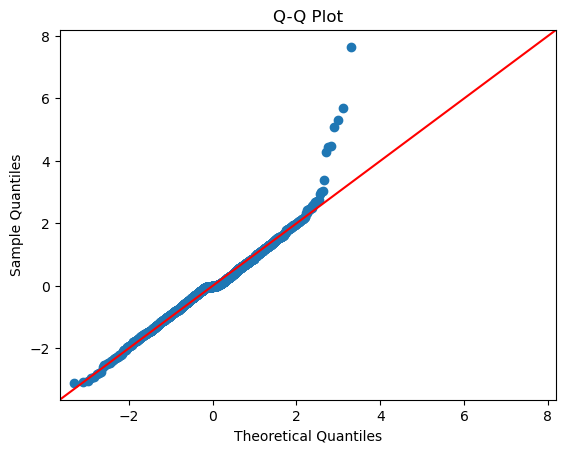

Shapiro-Wilk Test: Statistic = 0.973, p-value = 0.00000


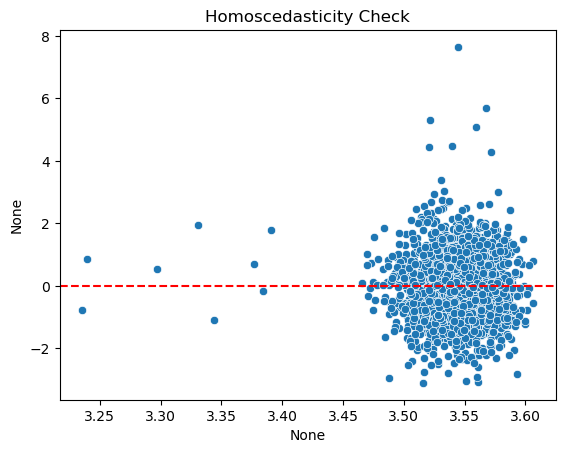

,Feature,VIF
0,Tech_Level_Encoded,1.000464
1,Labor Hours,1.000012
2,Financial Investment in Technology,1.000217
3,Environmental Impact Metrics,1.000407


Durbin-Watson: 2.079


In [60]:
X_sm = sm.add_constant(X_train_reg)
model_sm = sm.OLS(y_train_reg, X_sm).fit()

X_test_sm = sm.add_constant(X_test_reg)
y_pred_sm = model_sm.predict(X_test_sm)
residuals = y_test_reg - y_pred_sm

# Residual Plots
sns.histplot(residuals, kde=True)
plt.title("Residual Histogram")
plt.show()

sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot")
plt.show()

stat, p = shapiro(residuals)
print(f"Shapiro-Wilk Test: Statistic = {stat:.3f}, p-value = {p:.5f}")

# Homoscedasticity
sns.scatterplot(x=y_pred_sm, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Homoscedasticity Check")
plt.show()

# VIF
X_vif = pd.DataFrame(X_train_reg, columns=features)
vif_df = pd.DataFrame()
vif_df["Feature"] = X_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
display(vif_df)

# Durbin-Watson
dw = durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.3f}")

## Classification Model

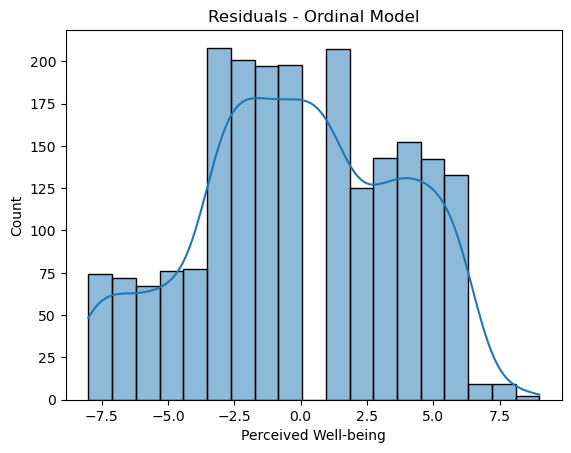

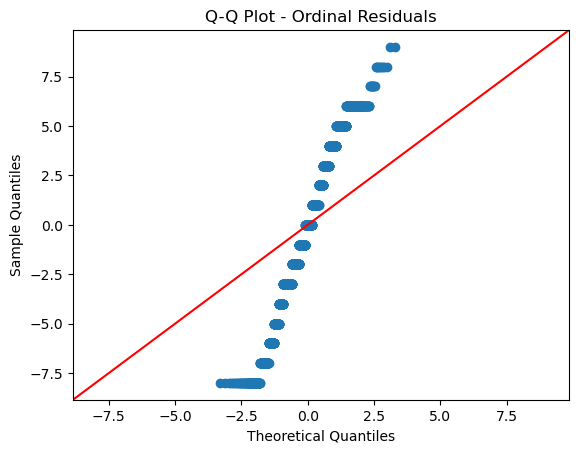

Shapiro-Wilk Test: Statistic = 0.974, p-value = 0.00000


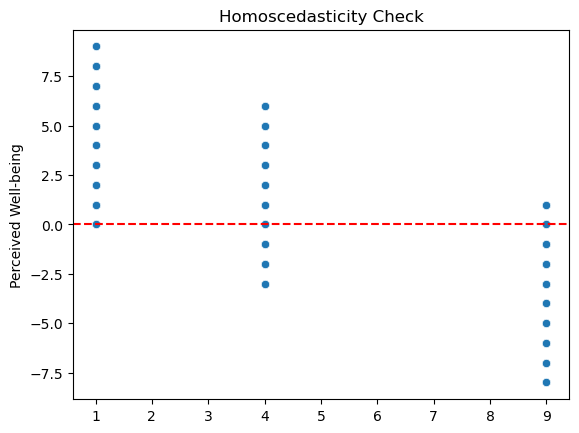

In [70]:
# Residual checks on ordinal model
residual = y_test_ord - y_pred_ord

# Histogram
sns.histplot(residual, kde=True)
plt.title("Residuals - Ordinal Model")
plt.show()

# Q-Q plot
import statsmodels.api as sm
sm.qqplot(residual, line='45')
plt.title("Q-Q Plot - Ordinal Residuals")
plt.show()

stat, p = shapiro(residual)
print(f"Shapiro-Wilk Test: Statistic = {stat:.3f}, p-value = {p:.5f}")

# Homoscedasticity
sns.scatterplot(x=y_pred_ord, y=residual)
plt.axhline(0, color='red', linestyle='--')
plt.title("Homoscedasticity Check")
plt.show()

# Step 12: Ridge + SHAP Interpretability

Best alpha: 10.0
R² Score: 0.00017435848359692585


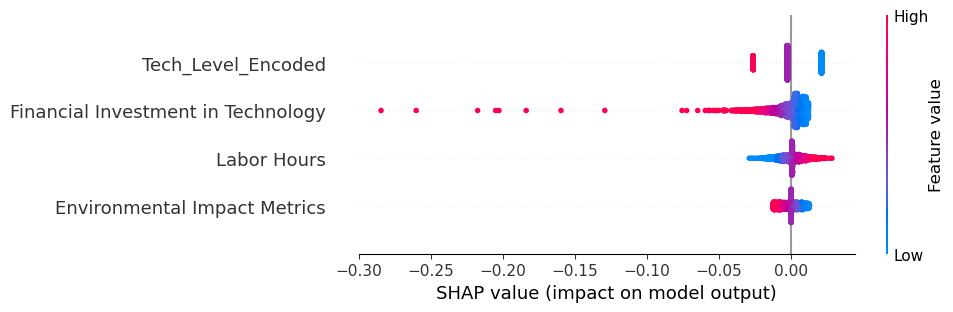

In [62]:
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
ridge.fit(X_train_reg, y_train_reg)
print("Best alpha:", ridge.alpha_)
print("R² Score:", ridge.score(X_test_reg, y_test_reg))

explainer = shap.Explainer(ridge, X_test_reg)
shap_values = explainer(X_test_reg)
shap.plots.beeswarm(shap_values)

# Step 13: Result

## Crop Yield Results

In [72]:
print("Regression Model Performance (Crop Yield)")
display(regression_results_df)

print("\nFeature Importance (Random Forest)")
display(feat_df)

print("\nANOVA Test: Crop Yield")
display(regression_anova_df)

print("\nOLS Model Summary")
print(model_sm.summary())

print("\nRidge Regression Summary")
print(f"Best Alpha: {ridge.alpha_}")
print(f"R² on Test Data: {ridge.score(X_test_reg, y_test_reg):.3f}")

Regression Model Performance (Crop Yield)


,Model,RMSE,R² Score
0,Linear Regression,0.991,0.000
1,Random Forest,1.056,-0.135
2,XGBoost,1.075,-0.177



Feature Importance (Random Forest)


,Feature,Importance
3,Environmental Impact Metrics,0.326946
2,Financial Investment in Technology,0.314123
1,Labor Hours,0.310985
0,Tech_Level_Encoded,0.047947



ANOVA Test: Crop Yield


,Feature,F-Statistic,p-value
0,Tech_Level_Encoded,1.3844,0.25051
1,Labor Hours,0.8726,0.41789
2,Financial Investment in Technology,0.2896,0.74858
3,Environmental Impact Metrics,0.4320,0.64919



OLS Model Summary
                            OLS Regression Results                            
Dep. Variable:             Crop Yield   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.347
Date:                Wed, 23 Apr 2025   Prob (F-statistic):              0.250
Time:                        10:09:13   Log-Likelihood:                -12397.
No. Observations:                8364   AIC:                         2.480e+04
Df Residuals:                    8359   BIC:                         2.484e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

## Perceived Well-being Results

In [73]:
# --- 1. Ordinal Logistic Regression Results ---
print("\nOrdinal Logistic Regression Summary (LogisticIT)\n")
print("Features used:", list(X.columns))

# Coefficients
print("\nModel Coefficients:")
for feature, coef in zip(X.columns, ord_model.coef_):
    print(f"  {feature}: {coef:.4f}")

# Thresholds (theta_)
print("\nThresholds (Theta values):")
for i, theta in enumerate(ord_model.theta_):
    print(f"  Threshold {i+1}: {theta:.4f}")

# Accuracy and Confusion Matrix
acc_ord = accuracy_score(y_test_ord, y_pred_ord)
print(f"\nOrdinal Prediction Accuracy: {acc_ord:.3f}")
print("\nOrdinal Confusion Matrix:")
print(confusion_matrix(y_test_ord, y_pred_ord))

# Sample predictions
print("\nSample Ordinal Predictions:")
ordinal_results_df = pd.DataFrame({
    'Actual': y_test_ord.reset_index(drop=True),
    'Predicted': y_pred_ord
})
display(ordinal_results_df.head(10))


# --- 2. Classification Results (3-class) ---
for name, model in classifiers.items():
    print(f"\n{name} Classification Results:")

    y_pred_cls = model.predict(X_test_cls)
    acc = accuracy_score(y_test_cls, y_pred_cls)
    print(f"Accuracy: {acc:.3f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_cls, y_pred_cls))
    print("Classification Report:")
    print(classification_report(y_test_cls, y_pred_cls))

    # Sample predictions
    print("\nSample Predictions:")
    sample_df = pd.DataFrame({
        "Actual": y_test_cls.reset_index(drop=True),
        "Predicted": y_pred_cls
    })
    display(sample_df.head(10))


# --- 3. Cross-Validation Results ---
print("\nOrdinal Logistic Regression CV Accuracy:")
print(f"Mean: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")

for name, model in classifiers.items():
    scores = cross_val_score(model, X, y_cls, cv=5, scoring='accuracy')
    print(f"{name} Classification CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")


# --- 4. Hyperparameter Tuning (Random Forest Classifier) ---
print("\nBest Hyperparameters (Random Forest Classifier):")
print(grid_rf.best_params_)
print(f"Best CV Accuracy: {grid_rf.best_score_:.3f}")


# --- 5. ANOVA & Tukey HSD ---
print("\nOne-Way ANOVA: Perceived Well-being")
display(classification_anova_df)


Ordinal Logistic Regression Summary (LogisticIT)

Features used: ['Tech_Level_Encoded', 'Labor Hours', 'Financial Investment in Technology', 'Environmental Impact Metrics']

Model Coefficients:
  Tech_Level_Encoded: -0.0095
  Labor Hours: 0.0036
  Financial Investment in Technology: -0.0039
  Environmental Impact Metrics: -0.0025

Thresholds (Theta values):
  Threshold 1: -0.0240
  Threshold 2: -0.0240
  Threshold 3: -0.0240
  Threshold 4: -0.0050
  Threshold 5: -0.0050
  Threshold 6: -0.0050
  Threshold 7: -0.0050
  Threshold 8: -0.0050
  Threshold 9: 0.0266

Ordinal Prediction Accuracy: 0.095

Ordinal Confusion Matrix:
[[  5   0   0 120   0   0   0   0  74   0]
 [  5   0   0 127   0   0   0   0  72   0]
 [  7   0   0 128   0   0   0   0  67   0]
 [  9   0   0 124   0   0   0   0  76   0]
 [  9   0   0 124   0   0   0   0  77   0]
 [ 10   0   0 118   0   0   0   0  88   0]
 [  6   0   0 134   0   0   0   0  74   0]
 [  9   0   0 143   0   0   0   0  69   0]
 [  9   0   0 132   0   0 

,Actual,Predicted
0,6,9
1,6,4
2,4,4
3,1,4
4,5,9
5,10,9
6,9,4
7,10,4
8,1,4
9,3,4



Logistic Regression Classification Results:
Accuracy: 0.406
Confusion Matrix:
[[  0   0 638]
 [  1   3 601]
 [  0   3 846]]
Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00       638
         Low       0.50      0.00      0.01       605
    Moderate       0.41      1.00      0.58       849

    accuracy                           0.41      2092
   macro avg       0.30      0.33      0.20      2092
weighted avg       0.31      0.41      0.24      2092


Sample Predictions:


,Actual,Predicted
0,Moderate,Moderate
1,Moderate,Moderate
2,Moderate,Moderate
3,Low,Moderate
4,Moderate,Moderate
5,High,Moderate
6,High,Moderate
7,High,Moderate
8,Low,Moderate
9,Low,Moderate



Random Forest Classification Results:
Accuracy: 0.360
Confusion Matrix:
[[187 154 297]
 [164 157 284]
 [231 209 409]]
Classification Report:
              precision    recall  f1-score   support

        High       0.32      0.29      0.31       638
         Low       0.30      0.26      0.28       605
    Moderate       0.41      0.48      0.44       849

    accuracy                           0.36      2092
   macro avg       0.35      0.34      0.34      2092
weighted avg       0.35      0.36      0.35      2092


Sample Predictions:


,Actual,Predicted
0,Moderate,Moderate
1,Moderate,Moderate
2,Moderate,Low
3,Low,Low
4,Moderate,Moderate
5,High,Low
6,High,Low
7,High,Moderate
8,Low,Moderate
9,Low,Low



Ordinal Logistic Regression CV Accuracy:
Mean: 0.102 ± 0.005
Logistic Regression Classification CV Accuracy: 0.397 ± 0.000
Random Forest Classification CV Accuracy: 0.348 ± 0.005

Best Hyperparameters (Random Forest Classifier):
{'max_depth': 5, 'n_estimators': 100}
Best CV Accuracy: 0.394

One-Way ANOVA: Perceived Well-being


,Feature,F-Statistic,p-value
0,Tech_Level_Encoded,1.1725,0.30963
1,Labor Hours,0.3121,0.73194
2,Financial Investment in Technology,0.8451,0.42955
3,Environmental Impact Metrics,0.8103,0.44475


# Save and Download Processed Data

In [65]:
df.to_csv("cleaned_farmers_data.csv", index=False)